In [1]:
import hydra
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from phd.feature_search.scripts.ensemble_feature_search import *

/home/ejmejm/local_projects/phd_research/phd/feature_search/scripts/ensemble_feature_search.py:685: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path='../conf', config_name='full_feature_search')


In [9]:
if not hydra.core.global_hydra.GlobalHydra().is_initialized():
    hydra.initialize(config_path="../../conf")

shared_params = [
    "task.n_features=30",
    "task.n_real_features=30",
    "task.noise_std=0.0",
    "train.total_steps=20_000",
    "seed=20250812",
    "train.log_freq=500",
    "comet_ml=false",
    "wandb=false",
    "model.hidden_dim=3000",
]

# Load hydra config
cfg = hydra.compose(
    config_name = "comet_sweeps/nonlinear_geoff_ablation_v5/base_config.yaml",
    overrides = [
        "+model.ensemble_feature_selection_method=random",
        "+model.feature_utility_mode=mean",
        "+model.ensemble_utility_mode=objective_improvement",
        "+model.prediction_mode=mean",
        "+feature_recycling.ensemble_recycle_rate=0.0",
        "+model.ensemble_dim=10_000",
        "+model.n_ensemble_members=1",
        *shared_params,
    ]
)

In [10]:
# Every time a new feature is introduced, check if it should be kept or not
# If it should be kept, track how long for the feature to rise in utility to top 10%
# But what is utility in an ensemble? I think for now I can just say it's the mean.

In [11]:
def compute_best_feature_match_counts(model, task):
    """Get, for each target feature, how closely the closest learning network hidden unit matches it."""
    optimal_feature_weights = task.weights[0].T
    feature_matches = model.input_layer.weight.unsqueeze(dim=1) == optimal_feature_weights.unsqueeze(dim=0)
    positive_feature_match_counts = feature_matches.sum(dim=2)
    negative_feature_match_counts = (~feature_matches).sum(dim=2)
    feature_match_counts = torch.maximum(positive_feature_match_counts, negative_feature_match_counts)
    best_feature_match_counts = feature_match_counts.max(dim=0).values
    return best_feature_match_counts

In [12]:
def prepare_experiment(cfg, imitate_no_ensemble=False):
    cfg = init_experiment(cfg.project, cfg)

    task, task_iterator, model, criterion, optimizer, repr_optimizer, recycler = \
        prepare_ltu_geoff_experiment(cfg)
    model.forward = model_distractor_forward_pass.__get__(model)

    distractor_tracker = DistractorTracker(
        model,
        cfg.task.distractor_chance,
        tuple(cfg.task.distractor_mean_range),
        tuple(cfg.task.distractor_std_range),
        seed = seed_from_string(cfg.seed, 'distractor_tracker'),
    )

    # Gives a 1:1 hidden dim to ensemble input mapping
    if imitate_no_ensemble:
        model.ensemble_input_ids = torch.arange(
                0, model.n_ensemble_members * model.ensemble_dim,
                dtype = torch.long,
                device = model.ensemble_input_ids.device,
            ).reshape(model.n_ensemble_members, model.ensemble_dim)

    # Distractor setup
    n_hidden_units = model.input_layer.out_features
    distractor_tracker.process_new_features(torch.arange(n_hidden_units))
    
    return task, task_iterator, model, criterion, optimizer, repr_optimizer, recycler, distractor_tracker

In [13]:
def run_experiment(
        cfg: DictConfig,
        task: NonlinearGEOFFTask,
        task_iterator: Iterator[Tuple[torch.Tensor, torch.Tensor]],
        model: EnsembleMLP,
        criterion: nn.Module,
        optimizer: Optimizer,
        repr_optimizer: Optional[Optimizer],
        distractor_tracker: DistractorTracker,
    ):
    # Training loop
    step = 0
    prev_pruned_idxs = set()
    prune_layer = model.activation
    optimal_feature_weights = task.weights[0].T
    best_feature_match_counts = compute_best_feature_match_counts(model, task)
    print(f'Best feature match counts: {best_feature_match_counts.tolist()}')
    
    # Setup progress bar
    for pbar in list(tqdm._instances):
        pbar.close()
    pbar = tqdm(total=cfg.train.total_steps, desc='Training')

    # Flags
    log_utility_stats = cfg.train.get('log_utility_stats', False)
    log_pruning_stats = cfg.train.get('log_pruning_stats', False)
    log_model_stats = cfg.train.get('log_model_stats', False)

    # Initialize accumulators
    cumulant_stats = StandardizationStats(gamma=0.99)
    pruning_state = PruningState()
    cumulative_loss = np.float128(0.0)
    loss_accum = 0.0
    ensemble_loss_accum = 0.0
    mean_pred_loss_accum = 0.0
    pruned_accum = 0
    pruned_newest_feature_accum = 0
    n_steps_since_log = 0
    total_features_pruned = 0
    total_ensembles_pruned = 0
    prune_thresholds = []
    target_buffer = []
    
    top_x_percent = 0.2
    times_to_top_x_percent = [] # Tuples of feature creation step and time to top x%
    suboptimal_prune_hist = [] # One entry per step that gives the number of prunes that step that were suboptimal
    tracked_features = {} # Maps feature idx to the step it was introduced
    
    
    while step < cfg.train.total_steps:

        ### Data Processing ###

        # Generate batch of data
        inputs, targets = next(task_iterator)

        # Add noise to targets
        if cfg.task.noise_std > 0:
            targets += torch.randn_like(targets) * cfg.task.noise_std
        
        with torch.no_grad():
            standardized_targets, cumulant_stats = standardize_targets(targets, cumulant_stats)
        
        if cfg.train.standardize_cumulants:
            targets = standardized_targets
        target_buffer.extend(targets.view(-1).tolist())
        
        features, targets = inputs.to(cfg.device), targets.to(cfg.device)


        ### Pruning ###

        if log_pruning_stats:
            pre_prune_feature_utilities = model.feature_utilities.ravel().cpu().clone().numpy()
            pre_prune_ensemble_utilities = model.ensemble_utilities.cpu().clone().numpy()
        
        pre_prune_feature_weights = model.input_layer.weight.clone()
        
        # Prune the model if necessary
        prune_results = prune_model(
            model, optimizer, distractor_tracker, pruning_state, cfg)
        
        # Update pruning metrics
        total_features_pruned += prune_results['n_features_pruned']
        total_ensembles_pruned += prune_results['n_ensembles_pruned']
        
        if prune_results['n_features_pruned'] > 0:
            feature_idxs_pruned = prune_results['feature_idxs_pruned'].tolist()
            
            # Log pruning statistics
            pruned_accum += len(feature_idxs_pruned)
            n_new_pruned_features = len(set(feature_idxs_pruned).intersection(prev_pruned_idxs))
            pruned_newest_feature_accum += n_new_pruned_features
            prev_pruned_idxs = set(feature_idxs_pruned)
            
            if log_pruning_stats:
                prune_thresholds.append(pre_prune_feature_utilities[feature_idxs_pruned].max())
                
            ## Stop tracking pruned features
            
            for feature_idx in feature_idxs_pruned:
                # If the feature is pruned while still being tracked, then it never made it to top x%
                if feature_idx in tracked_features:
                    times_to_top_x_percent.append(
                        (tracked_features[feature_idx], -1))
                    tracked_features.pop(feature_idx)
            
            ## Check if any of the pruned feature should not have been pruned
            
            pruned_feature_weights = pre_prune_feature_weights[feature_idxs_pruned] # (n_features_pruned, input_dim)
            feature_matches = pruned_feature_weights.unsqueeze(dim=1) == optimal_feature_weights.unsqueeze(dim=0)
            positive_match_counts = feature_matches.sum(dim=2)
            negative_match_counts = (~feature_matches).sum(dim=2)
            match_counts = torch.maximum(positive_match_counts, negative_match_counts) # (n_features_pruned, n_target_features)
            tied_or_better_feature_matrix = match_counts >= best_feature_match_counts.unsqueeze(dim=0)
            tied_or_better_feature_arr = tied_or_better_feature_matrix.any(dim=1) # (n_features_pruned,)
            n_suboptimal_prunes = tied_or_better_feature_arr.sum().item()
            suboptimal_prune_hist.append(n_suboptimal_prunes)
            
            ## Track features that are the new best features
            
            new_feature_weights = model.input_layer.weight[feature_idxs_pruned]
            feature_matches = new_feature_weights.unsqueeze(dim=1) == optimal_feature_weights.unsqueeze(dim=0)
            positive_match_counts = feature_matches.sum(dim=2)
            negative_match_counts = (~feature_matches).sum(dim=2)
            match_counts = torch.maximum(positive_match_counts, negative_match_counts) # (n_features_pruned, n_target_features)
            feature_improvement_matrix = match_counts > best_feature_match_counts.unsqueeze(dim=0)
            
            # Bool for each new feature that indicates if it is an overall improvement
            new_best_feature = feature_improvement_matrix.any(dim=1) # (n_features_pruned,)
            
            for i in range(len(feature_idxs_pruned)):
                feature_idx = feature_idxs_pruned[i]
                if new_best_feature[i]:
                    tracked_features[feature_idx] = step
                    
            best_feature_match_counts = compute_best_feature_match_counts(model, task)
        
        
        ### Track time to top x% ###
        
        utility_treshold = torch.quantile(model.feature_utilities, 1 - top_x_percent)
        feature_utilities = model.feature_utilities.cpu().clone().numpy()
        for feature_idx in list(tracked_features.keys()):
            if feature_utilities[feature_idx] > utility_treshold:
                times_to_top_x_percent.append(
                    (tracked_features[feature_idx], step - tracked_features[feature_idx]))
                tracked_features.pop(feature_idx)
        
        
        ### Forward Pass ###
        
        outputs, param_inputs, aux = model(
            features, targets, update_state=True,
            distractor_callback=distractor_tracker.replace_features,
        )
        loss = aux['loss']
        ensemble_loss_sum = aux['ensemble_losses'].sum()
        
        with torch.no_grad():
            if cfg.train.standardize_cumulants:
                baseline_pred = torch.zeros_like(targets)
            else:
                baseline_pred = cumulant_stats.running_mean.cpu().view(1, 1)
            mean_pred_loss = criterion(baseline_pred, targets)


        ### Backward Pass ###

        # Backward pass
        optimizer.zero_grad()
        if repr_optimizer is not None:
            repr_optimizer.zero_grad()
        
        if isinstance(optimizer, IDBD):
            # Mean over batch dimension
            param_inputs = {k: v.mean(dim=0) for k, v in param_inputs.items()}
            retain_graph = optimizer.version == 'squared_grads'
            ensemble_loss_sum.backward(retain_graph=retain_graph)
            optimizer.step(aux['ensemble_predictions'], param_inputs)
        else:
            ensemble_loss_sum.backward()
            optimizer.step()
            
        if repr_optimizer is not None:
            repr_optimizer.step()
            
        
        ### Metrics ###
        
        # Accumulate metrics
        loss_accum += loss.item()
        ensemble_loss_accum += ensemble_loss_sum.item()
        cumulative_loss += loss.item()
        mean_pred_loss_accum += mean_pred_loss.item()
        n_steps_since_log += 1
        
        
        ### Logging ###
        
        if step % cfg.train.log_freq == 0:
            n_distractors = distractor_tracker.distractor_mask.sum().item()
            n_real_features = distractor_tracker.distractor_mask.numel() - n_distractors
            metrics = {
                'step': step,
                'samples': step * cfg.train.batch_size,
                'loss': loss_accum / n_steps_since_log,
                'avg_ensemble_loss': ensemble_loss_accum / model.n_ensemble_members / n_steps_since_log,
                'cumulative_loss': float(cumulative_loss),
                'mean_prediction_loss': mean_pred_loss_accum / n_steps_since_log,
                'squared_targets': torch.tensor(target_buffer).square().mean().item(),
                'n_distractors': n_distractors,
                'n_real_features': n_real_features,
            }

            # Add model statistics separately for real and distractor features
            if log_model_stats:
                real_feature_masks = [
                    torch.ones(model.layers[0].weight.shape[1], dtype=torch.bool, device=model.layers[0].weight.device),
                    ~distractor_tracker.distractor_mask,
                ]
                metrics.update(get_model_statistics(
                    model, features, param_inputs, real_feature_masks, metric_prefix='real_'))
                
                distractor_feature_masks = [
                    real_feature_masks[0],
                    distractor_tracker.distractor_mask,
                ]
                metrics.update(get_model_statistics(
                    model, features, param_inputs, distractor_feature_masks, metric_prefix='distractor_'))

            log_metrics(metrics, cfg, step=step)
            
            pbar.set_postfix(loss=metrics['loss'])
            pbar.update(cfg.train.log_freq)
            
            # Reset accumulators
            loss_accum = 0.0
            mean_pred_loss_accum = 0.0
            ensemble_loss_accum = 0.0
            n_steps_since_log = 0
            target_buffer = []

        step += 1

    pbar.close()
    
    return {
        'times_to_top_x_percent': times_to_top_x_percent,
        'suboptimal_prune_hist': suboptimal_prune_hist,
    }

In [14]:
# cfg.train.total_steps = 15_000

In [17]:
cfg = hydra.compose(
    config_name = "comet_sweeps/nonlinear_geoff_ablation_v5/base_config.yaml",
    overrides = [
        *shared_params,
        "task.noise_std=0.0",
        "+model.ensemble_feature_selection_method=random",
        "+model.feature_utility_mode=mean",
        "+model.ensemble_utility_mode=objective_improvement",
        "+model.prediction_mode=mean",
        "+feature_recycling.ensemble_recycle_rate=0.0",
        "+model.ensemble_dim=3000",
        "+model.n_ensemble_members=1",
    ]
)
(task, task_iterator, model, criterion, optimizer,
    repr_optimizer, recycler, distractor_tracker) = prepare_experiment(cfg, imitate_no_ensemble=True)
monolith_results = run_experiment(cfg, task, task_iterator, model, criterion, optimizer, repr_optimizer, distractor_tracker)

Training:   5%|▌         | 1000/20000 [00:06<02:04, 152.99it/s, loss=1.47]


Best feature match counts: [24, 25, 25, 26, 25, 24, 25, 24, 26, 24, 25, 25, 25, 25, 25, 24, 23, 24, 24, 24]


Training: 100%|██████████| 20000/20000 [02:02<00:00, 162.65it/s, loss=0.383]


In [34]:
# Load hydra config
cfg = hydra.compose(
    config_name = "comet_sweeps/nonlinear_geoff_ablation_v5/base_config.yaml",
    overrides = [
        *shared_params,
        "task.noise_std=0.0",
        "+model.ensemble_feature_selection_method=random",
        "+model.feature_utility_mode=best",
        "+model.ensemble_utility_mode=objective_improvement",
        "+model.prediction_mode=mean",
        "+feature_recycling.ensemble_recycle_rate=0.0",
        "+model.ensemble_dim=300",
        "+model.n_ensemble_members=100",
    ]
)
(task, task_iterator, model, criterion, optimizer,
    repr_optimizer, recycler, distractor_tracker) = prepare_experiment(cfg, imitate_no_ensemble=False)
ensemble_results = run_experiment(cfg, task, task_iterator, model, criterion, optimizer, repr_optimizer, distractor_tracker)

Best feature match counts: [24, 26, 25, 25, 25, 25, 25, 24, 26, 24, 25, 24, 25, 25, 23, 24, 24, 25, 24, 24]


Training: 100%|██████████| 20000/20000 [02:02<00:00, 163.35it/s, loss=0.378]


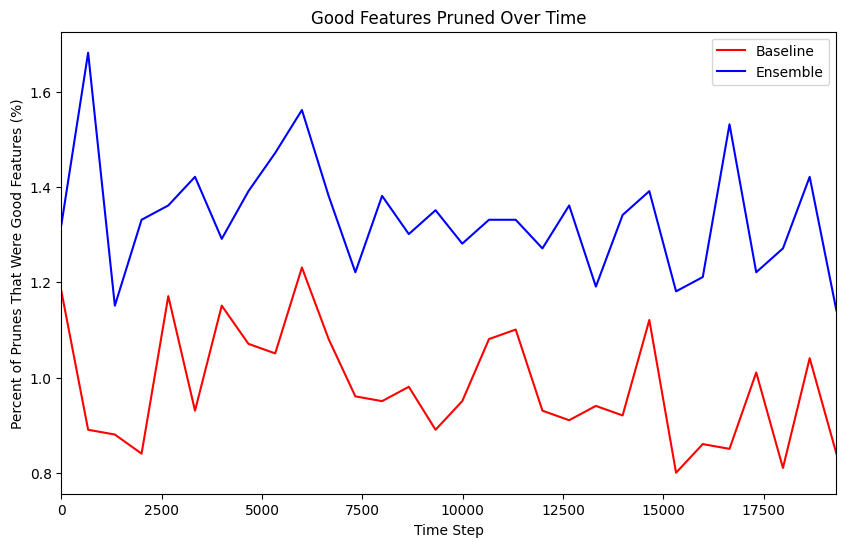

In [30]:
def bucket_and_average(data, n_buckets=30):
    data = np.array(data)
    bucket_size = len(data) // n_buckets
    truncated_data = data[:bucket_size * n_buckets]
    reshaped = truncated_data.reshape(n_buckets, bucket_size)
    return np.mean(reshaped, axis=1)

# Process both results
n_timesteps = len(monolith_results['suboptimal_prune_hist'])
n_buckets = 30
monolith_bucketed = bucket_and_average(
    monolith_results['suboptimal_prune_hist'], n_buckets=n_buckets)
ensemble_bucketed = bucket_and_average(
    ensemble_results['suboptimal_prune_hist'], n_buckets=n_buckets)

prunes_per_step = cfg.feature_recycling.recycle_rate * cfg.model.hidden_dim
monolith_bucketed *= 100.0 / prunes_per_step
ensemble_bucketed *= 100.0 / prunes_per_step

# Create x-axis points (representing time buckets)
x = np.arange(0, n_timesteps, n_timesteps // n_buckets)[:n_buckets]
# Create plot
plt.figure(figsize=(10, 6))
sns.lineplot(x=x, y=monolith_bucketed, color='red', label='Baseline')
sns.lineplot(x=x, y=ensemble_bucketed, color='blue', label='Ensemble')
plt.xlabel('Time Step')
plt.xlim(0, max(x))
plt.ylabel('Percent of Prunes That Were Good Features (%)')
plt.title('Good Features Pruned Over Time')
plt.show()


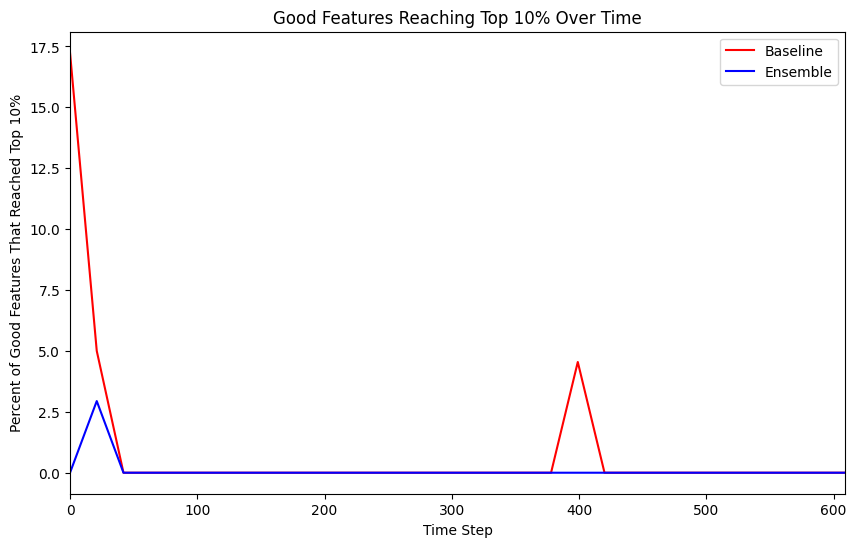

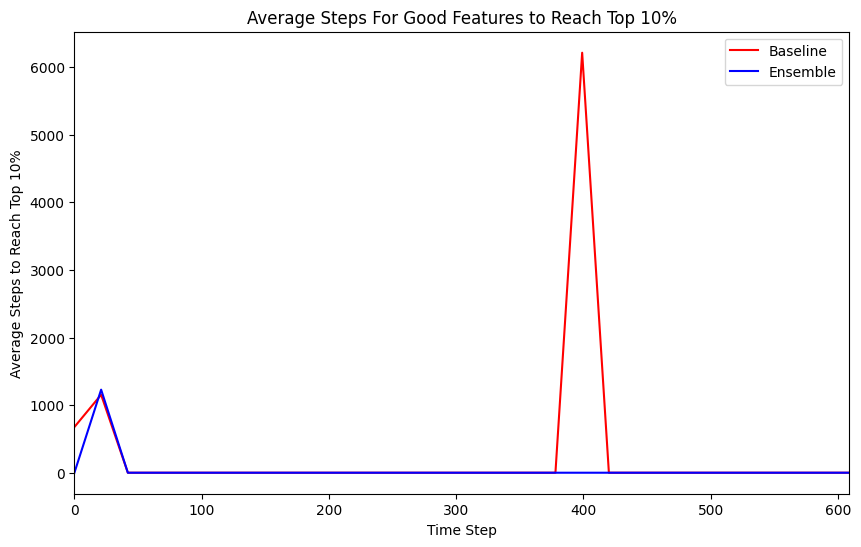

In [31]:
# times_to_threshold is a list of tuples of (creation_step, time_to_top_10_percent)
def convert_to_bucketed_time_stats(times_to_threshold, n_buckets=30):
    max_timestep = max([t[0] for t in times_to_threshold])
    bucket_size = max_timestep // n_buckets
    
    bucketed_total_time_to_threshold = [0 for _ in range(n_buckets)]
    bucket_reached_threshold_counts = [0 for _ in range(n_buckets)]
    bucket_counts = [0 for _ in range(n_buckets)]
    
    for creation_step, time_to_threshold in times_to_threshold:
        bucket_idx = min(creation_step // bucket_size, n_buckets - 1)
        bucket_counts[bucket_idx] += 1
        if time_to_threshold >= 0:
            bucketed_total_time_to_threshold[bucket_idx] += time_to_threshold
            bucket_reached_threshold_counts[bucket_idx] += 1
            
    bucketed_frac_to_threshold = [
        bucket_reached_threshold_counts[i] / bucket_counts[i]
        if bucket_counts[i] > 0 else 0
        for i in range(n_buckets)
    ]
    bucketed_avg_time_to_threshold = [
        bucketed_total_time_to_threshold[i] / bucket_reached_threshold_counts[i]
        if bucket_reached_threshold_counts[i] > 0 else 0
        for i in range(n_buckets)
    ]
    return bucketed_avg_time_to_threshold, bucketed_frac_to_threshold # Returns average time to top 10%, fraction that reached top 10%

# Process both results
n_timesteps = len(monolith_results['times_to_top_x_percent'])
n_buckets = 30
monolith_time_to_threshold, monolith_frac_reached_threshold = convert_to_bucketed_time_stats(
    monolith_results['times_to_top_x_percent'], n_buckets=n_buckets)
ensemble_time_to_threshold, ensemble_frac_reached_threshold = convert_to_bucketed_time_stats(
    ensemble_results['times_to_top_x_percent'], n_buckets=n_buckets)

monolith_percent_reached_threshold = [f * 100.0 for f in monolith_frac_reached_threshold]
ensemble_percent_reached_threshold = [f * 100.0 for f in ensemble_frac_reached_threshold]

# Create x-axis points (representing time buckets)
x = np.arange(0, n_timesteps, n_timesteps // n_buckets)[:n_buckets]

plt.figure(figsize=(10, 6))
sns.lineplot(x=x, y=monolith_percent_reached_threshold, color='red', label='Baseline')
sns.lineplot(x=x, y=ensemble_percent_reached_threshold, color='blue', label='Ensemble')
plt.xlabel('Time Step')
plt.xlim(0, max(x))
plt.ylabel('Percent of Good Features That Reached Top 10%')
plt.title('Good Features Reaching Top 10% Over Time')
plt.show()

# Create plots
plt.figure(figsize=(10, 6))
sns.lineplot(x=x, y=monolith_time_to_threshold, color='red', label='Baseline')
sns.lineplot(x=x, y=ensemble_time_to_threshold, color='blue', label='Ensemble')
plt.xlabel('Time Step')
plt.xlim(0, max(x))
plt.ylabel('Average Steps to Reach Top 10%')
plt.title('Average Steps For Good Features to Reach Top 10%')
plt.show()

In [32]:
top_10_monolith_times = list(zip(*monolith_results['times_to_top_10_percent']))
monolith_xs = np.array(top_10_monolith_times[0])
monolith_ys = np.array(top_10_monolith_times[1])
valid_monolith = monolith_ys != -1
monolith_xs = monolith_xs[valid_monolith]
monolith_ys = monolith_ys[valid_monolith]

top_10_ensemble_times = list(zip(*ensemble_results['times_to_top_10_percent']))
ensemble_xs = np.array(top_10_ensemble_times[0])
ensemble_ys = np.array(top_10_ensemble_times[1])
valid_ensemble = ensemble_ys != -1
ensemble_xs = ensemble_xs[valid_ensemble]
ensemble_ys = ensemble_ys[valid_ensemble]

plt.figure(figsize=(10, 6))
plt.scatter(monolith_xs, monolith_ys, label='Monolith', alpha=0.5, color='red')
plt.scatter(ensemble_xs, ensemble_ys, label='Ensemble', alpha=0.5, color='blue')
plt.xlabel('Creation Step')
plt.ylabel('Time to Top 10%')
plt.title('Time to Top 10% vs Creation Step')
plt.legend()
plt.show()

KeyError: 'times_to_top_10_percent'